Plots for learning harmonic functions
with neural networks.

## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import dataclasses
import json
import logging
import pickle
import sys
import tempfile

import mlflow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

import torch
import torch.nn as nn
import torch.nn.functional as F

from simple_parsing.helpers import Serializable

In [3]:
sys.path.append("..")

from src.experiments.harmonics.run_experiment import ExperimentConfig
from src.experiments.harmonics.fc_net import FCNet, FCNetConfig
from src.experiments.harmonics.harmonics import (
    HarmonicDataModule,
    HarmonicFn,
    HarmonicFnTrainable,
    HarmonicFnConfig,
)
import src.utils as utils
utils.mlflow_init()

## Load experimental data

In [4]:
def split_metric_history_by_trial(
    metrics: list[mlflow.entities.metric.Metric]
) -> tuple[np.ndarray, np.ndarray]:
    """Splits up metrics by trial"""
    
    mdict: dict[int, list[float]] = defaultdict(list)
    for m in metrics:
        mdict[2 ** m.step].append(m.value)
    
    keys = sorted(mdict.keys())
    max_trials = max(len(vs) for vs in mdict.values())
    
    ret = np.full(shape=(len(keys), max_trials), fill_value=np.nan)
    for i, k in enumerate(keys):
        for j, v in enumerate(mdict[k]):
            ret[i, j] = v
    
    return np.array(keys), ret

    
@dataclasses.dataclass
class RunResult:
    run_id: str
    name: str = ""
        
    cfg: ExperimentConfig = dataclasses.field(init=False)
    
    hf: HarmonicFn = dataclasses.field(init=False)
    
    ns: np.ndarray = dataclasses.field(init=False)
    train_mses: np.ndarray = dataclasses.field(init=False)
    val_mses: np.ndarray = dataclasses.field(init=False)
    epochs: np.ndarray = dataclasses.field(init=False)
    # TODO: num_dps: jnp.ndarray = dataclasses.field(init=False)
    
    def __post_init__(self):
        client = mlflow.tracking.MlflowClient()
        
        self.cfg = utils.mlflow_read_pkl(
            run_id=self.run_id,
            rel_artifact_path="config.pkl"
        )
        self.hf = utils.mlflow_read_pkl(
            run_id=self.run_id,
            rel_artifact_path="hf.pkl"
        )
        
        self.ns, self.train_mses = split_metric_history_by_trial(
            client.get_metric_history(self.run_id, 'train_mse')
        )
        _, self.val_mses = split_metric_history_by_trial(
            client.get_metric_history(self.run_id, 'val_mse')
        )
        _, self.epochs = split_metric_history_by_trial(
            client.get_metric_history(self.run_id, 'epochs')
        )

In [5]:
%%time
RUNS: dict[str, RunResult] = dict(
    b2c04n032=RunResult(run_id="d28c316e8f3f474487dd0ad5131279a2"),
    b2c04n064=RunResult(run_id="480477b47f0d4da698eed6718dc3afaa"),
    b2c04n128=RunResult(run_id="20b79ced33534d22be84411c53a764a5"),
    
    b3c04n032=RunResult(run_id="b8a443d70b0d49888431750c4099abfb"),
    b3c04n064=RunResult(run_id="e6636c056bb8491298e50970f454ac33"),
    b3c04n128=RunResult(run_id="e65cc5274e6042ecaf0030b2185d4b6c"),
    
    b2c16n032=RunResult(run_id="6c3e2be5d4a34183a358a120e3162516"),
    b2c16n064=RunResult(run_id="afe3dcfe45874f28b67ac4442634a699"),
    b2c16n128=RunResult(run_id="70d5ea06a22944178a03a34fdc081c3f"),
    
    b3c16n032=RunResult(run_id="4673f4e7b05c4036a1d628d6aa90a393"),
    b3c16n064=RunResult(run_id="c9a8e36edc04487192bc5a88022e0968"),
    b3c16n128=RunResult(run_id="231b156ee78c4bc39ae8aef559019d81"),
)

CPU times: user 2.43 s, sys: 295 ms, total: 2.72 s
Wall time: 4 s


## Generate least-squares reconstruction data

In [6]:
def get_mse(
    model: pl.LightningModule,
    dl: torch.utils.data.DataLoader,
):
    return pl.Trainer(
        enable_progress_bar=False,
    ).test(
        model=model,
        dataloaders=dl,
        verbose=False,
    )[0]['test_mse']

@dataclasses.dataclass(frozen=True)
class LSData:
    bandlimit: int
    noise_std: float
    
    ns: np.ndarray
    val_mses: np.ndarray

    
def run_lstsq_exp(
    ns: list[int],
    true_hf: HarmonicFn,
    bandlimit: int,
    cfg: ExperimentConfig,
    n_trials: int = 1,
    noise_std: float = 0.0,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        mses = []
        for trial_idx in range(n_trials):
            dm = HarmonicDataModule(
                hf=true_hf,
                n_train=n_train,
                n_val=cfg.n_val,
                train_seed=trial_idx,
                val_seed=cfg.val_seed,
                num_workers=cfg.num_workers,
                batch_size=cfg.batch_size,
            )
            dm.setup()

            hf_hat = HarmonicFn.construct_via_lstsq(
                xs=dm.train_ds.tensors[0].numpy(),
                ys=dm.train_ds.tensors[1].numpy(),
                bandlimit=bandlimit,
                coeff_threshold=1e-6,
                lamb=1e-9,
            )

            mse = get_mse(model=hf_hat, dl=dm.val_dataloader())
            mses.append(mse)
        val_mses.append(mses)
    
    return LSData(
        bandlimit=bandlimit,
        noise_std=noise_std,
        ns=np.array(ns),
        val_mses=np.array(val_mses),
    )

In [7]:
LS_DATA = dict()

In [8]:
LS_DATA["b2c04-b1"] = run_lstsq_exp(
    ns=list(range(1, 400, 2))
            + [2 ** x for x in range(9, 18)],
    true_hf=RUNS["b2c04n032"].hf,
    bandlimit=1,
    cfg=RUNS["b2c04n032"].cfg,
)
LS_DATA["b2c04-b2"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32]
            + list(range(50, 400))
            + [512, 1024, 2048, 5096],
    true_hf=RUNS["b2c04n032"].hf,
    bandlimit=2,
    cfg=RUNS["b2c04n032"].cfg,
)
LS_DATA["b2c04-b3"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128]
            + list(range(200, 1000, 10))
            + [1024, 2048, 5096],
    true_hf=RUNS["b2c04n032"].hf,
    bandlimit=3,
    cfg=RUNS["b2c04n032"].cfg,
)
LS_DATA["b2c04-b4"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128, 256]
            + list(range(500, 2000, 25))
            + [2048, 5096],
    true_hf=RUNS["b2c04n032"].hf,
    bandlimit=4,
    cfg=RUNS["b2c04n032"].cfg,
)

100%|██████████| 71/71 [00:17<00:00,  4.03it/s]


In [9]:
LS_DATA["b2c16-b1"] = run_lstsq_exp(
    ns=list(range(1, 400, 2))
            + [2 ** x for x in range(9, 18)],
    true_hf=RUNS["b2c16n032"].hf,
    bandlimit=1,
    cfg=RUNS["b2c16n032"].cfg,
)
LS_DATA["b2c16-b2"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32]
            + list(range(50, 400))
            + [512, 1024, 2048, 5096],
    true_hf=RUNS["b2c16n032"].hf,
    bandlimit=2,
    cfg=RUNS["b2c16n032"].cfg,
)
LS_DATA["b2c16-b3"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128]
            + list(range(200, 1000, 10))
            + [1024, 2048, 5096],
    true_hf=RUNS["b2c16n032"].hf,
    bandlimit=3,
    cfg=RUNS["b2c16n032"].cfg,
)
LS_DATA["b2c16-b4"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128, 256]
            + list(range(500, 2000, 25))
            + [2048, 5096],
    true_hf=RUNS["b2c16n032"].hf,
    bandlimit=4,
    cfg=RUNS["b2c16n032"].cfg,
)

100%|██████████| 71/71 [00:17<00:00,  4.11it/s]


In [10]:
LS_DATA["b3c04-b2"] = run_lstsq_exp(
    ns=list(range(1, 1000, 10))
            + [2 ** x for x in range(10, 18)],
    true_hf=RUNS["b3c04n032"].hf,
    bandlimit=2,
    cfg=RUNS["b3c04n032"].cfg,
)
LS_DATA["b3c04-b3"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128, 256]
            + list(range(200, 2000, 20))
            + [2048, 5096],
    true_hf=RUNS["b3c04n032"].hf,
    bandlimit=3,
    cfg=RUNS["b3c04n032"].cfg,
)
LS_DATA["b3c04-b4"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128, 256]
            + list(range(400, 4000, 40))
            + [5096],
    true_hf=RUNS["b3c04n032"].hf,
    bandlimit=4,
    cfg=RUNS["b3c04n032"].cfg,
)

100%|██████████| 100/100 [00:28<00:00,  3.54it/s]


In [11]:
LS_DATA["b3c16-b2"] = run_lstsq_exp(
    ns=list(range(1, 1000, 10))
            + [2 ** x for x in range(10, 18)],
    true_hf=RUNS["b3c16n032"].hf,
    bandlimit=2,
    cfg=RUNS["b3c16n032"].cfg,
)
LS_DATA["b3c16-b3"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128, 256]
            + list(range(200, 2000, 20))
            + [2048, 5096],
    true_hf=RUNS["b3c16n032"].hf,
    bandlimit=3,
    cfg=RUNS["b3c16n032"].cfg,
)
LS_DATA["b3c16-b4"] = run_lstsq_exp(
    ns=[1, 2, 4, 8, 16, 32, 64, 128, 256]
            + list(range(400, 4000, 40))
            + [5096],
    true_hf=RUNS["b3c16n032"].hf,
    bandlimit=4,
    cfg=RUNS["b3c16n032"].cfg,
)

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


# Plots

In [12]:
def plot_errorbar(
    xs: np.ndarray,
    ys: np.ndarray,
    lo_q: float = 0,
    mid_q: float = 0.5,
    hi_q: float = 1,
    **plt_kwargs
):    
    lo  = np.quantile(ys, lo_q, axis=-1)
    mid = np.quantile(ys, mid_q, axis=-1)
    hi  = np.quantile(ys, hi_q, axis=-1)
        
    plt.errorbar(
        x=xs[mid != np.nan],
        y=mid[mid != np.nan],
        yerr=np.stack([mid-lo, hi-mid])[:, mid != np.nan],
        **plt_kwargs
    )

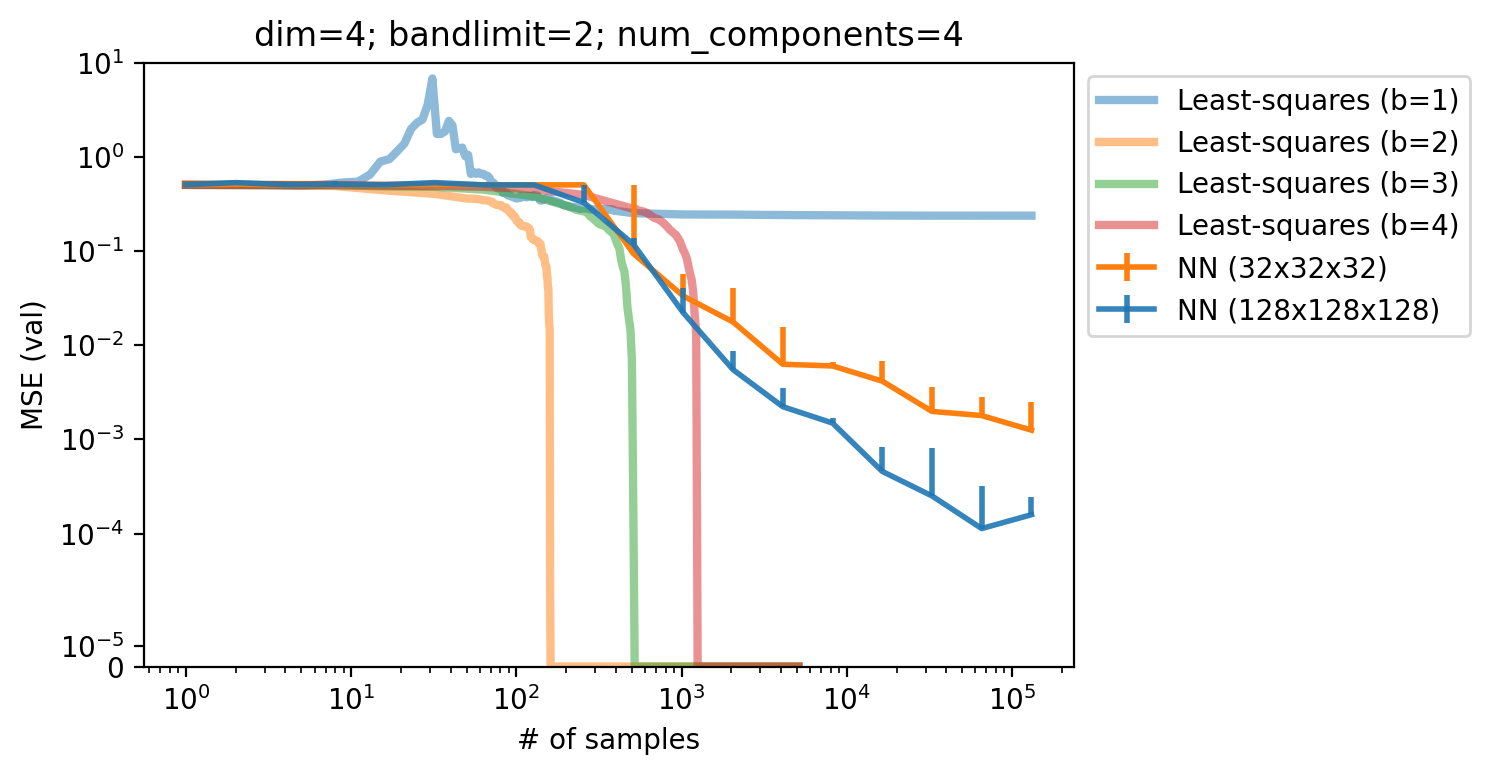

In [13]:
plt.figure(dpi=200, figsize=(6, 4))

plot_errorbar(
    xs=RUNS["b2c04n032"].ns,
    ys=RUNS["b2c04n032"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=1, zorder=8, linewidth=2, color="tab:orange",
    label="NN (32x32x32)",   
)
plot_errorbar(
    xs=RUNS["b2c04n128"].ns,
    ys=RUNS["b2c04n128"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=0.9, zorder=9, linewidth=2, color="tab:blue",
    label="NN (128x128x128)",
)
#plot_errorbar(
#    xs=RUNS["b2c04n064"].ns,
#    ys=RUNS["b2c04n064"].val_mses,
#    lo_q=0, mid_q=0, hi_q=1,
#    alpha=0.8, zorder=10, label="NN (64x64x64)"
#)

plt.plot(LS_DATA["b2c04-b1"].ns, LS_DATA["b2c04-b1"].val_mses.min(axis=-1), label="Least-squares (b=1)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b2c04-b2"].ns, LS_DATA["b2c04-b2"].val_mses.min(axis=-1), label="Least-squares (b=2)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b2c04-b3"].ns, LS_DATA["b2c04-b3"].val_mses.min(axis=-1), label="Least-squares (b=3)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b2c04-b4"].ns, LS_DATA["b2c04-b4"].val_mses.min(axis=-1), label="Least-squares (b=4)", alpha=0.5, linewidth=3)

plt.xscale("log");
plt.yscale('symlog', linthresh=5e-5); plt.ylim(0, 10)

plt.title("dim=4; bandlimit=2; num_components=4")
plt.xlabel("# of samples")
plt.ylabel("MSE (val)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));

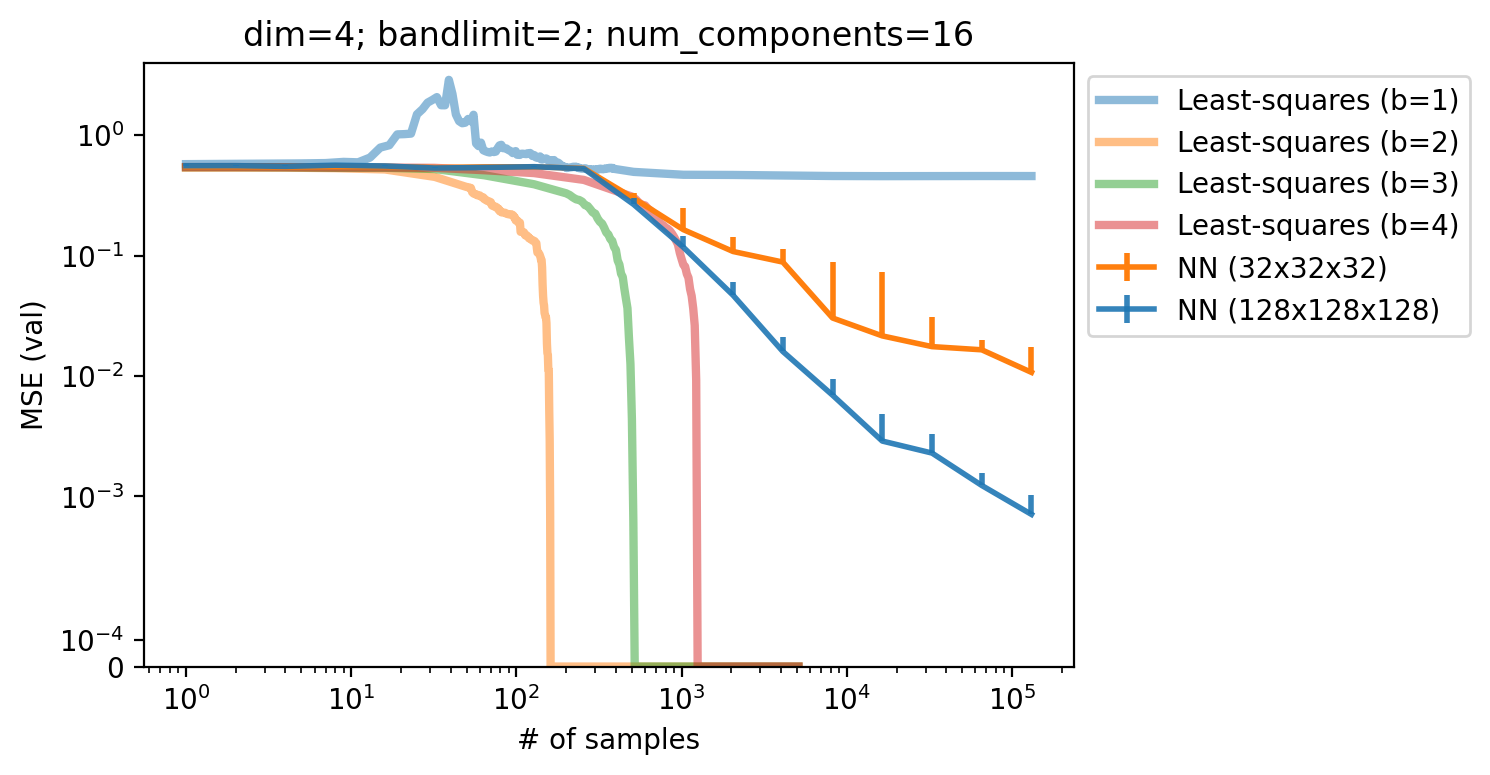

In [14]:
plt.figure(dpi=200, figsize=(6, 4))

plot_errorbar(
    xs=RUNS["b2c16n032"].ns,
    ys=RUNS["b2c16n032"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=1, zorder=8, linewidth=2, color="tab:orange",
    label="NN (32x32x32)",   
)
plot_errorbar(
    xs=RUNS["b2c16n128"].ns,
    ys=RUNS["b2c16n128"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=0.9, zorder=9, linewidth=2, color="tab:blue",
    label="NN (128x128x128)",
)
#plot_errorbar(
#    xs=RUNS["b2c16n064"].ns,
#    ys=RUNS["b2c16n064"].val_mses,
#    lo_q=0, mid_q=0, hi_q=1,
#    alpha=0.8, zorder=10, label="NN (64x64x64)"
#)

plt.plot(LS_DATA["b2c16-b1"].ns, LS_DATA["b2c16-b1"].val_mses.min(axis=-1), label="Least-squares (b=1)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b2c16-b2"].ns, LS_DATA["b2c16-b2"].val_mses.min(axis=-1), label="Least-squares (b=2)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b2c16-b3"].ns, LS_DATA["b2c16-b3"].val_mses.min(axis=-1), label="Least-squares (b=3)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b2c16-b4"].ns, LS_DATA["b2c16-b4"].val_mses.min(axis=-1), label="Least-squares (b=4)", alpha=0.5, linewidth=3)

plt.xscale("log");
plt.yscale('symlog', linthresh=5e-4); plt.ylim(0, 4)

plt.title("dim=4; bandlimit=2; num_components=16")
plt.xlabel("# of samples")
plt.ylabel("MSE (val)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));

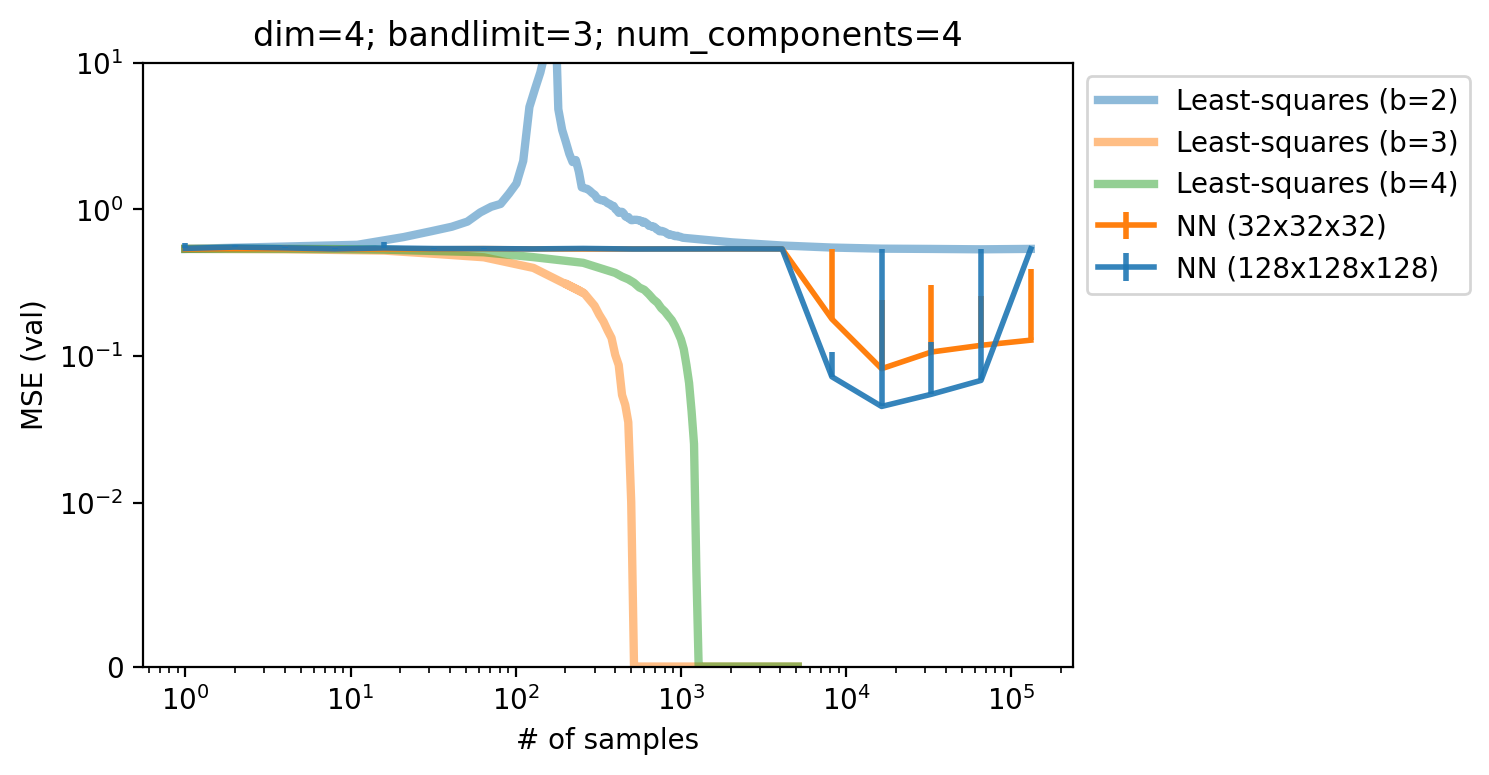

In [15]:
plt.figure(dpi=200, figsize=(6, 4))

plot_errorbar(
    xs=RUNS["b3c04n032"].ns,
    ys=RUNS["b3c04n032"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=1, zorder=8, linewidth=2, color="tab:orange",
    label="NN (32x32x32)",
)
plot_errorbar(
    xs=RUNS["b3c04n128"].ns,
    ys=RUNS["b3c04n128"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=0.9, zorder=9, linewidth=2, color="tab:blue",
    label="NN (128x128x128)",
)
#plot_errorbar(
#    xs=RUNS["b3c16n064"].ns,
#    ys=RUNS["b3c16n064"].val_mses,
#    lo_q=0, mid_q=0, hi_q=1,
#    alpha=0.8, zorder=10, label="NN (64x64x64)"
#)

plt.plot(LS_DATA["b3c04-b2"].ns, LS_DATA["b3c04-b2"].val_mses.min(axis=-1), label="Least-squares (b=2)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b3c04-b3"].ns, LS_DATA["b3c04-b3"].val_mses.min(axis=-1), label="Least-squares (b=3)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b3c04-b4"].ns, LS_DATA["b3c04-b4"].val_mses.min(axis=-1), label="Least-squares (b=4)", alpha=0.5, linewidth=3)

plt.xscale("log")
plt.yscale('symlog', linthresh=1e-2);
plt.ylim(0, 10)

plt.title("dim=4; bandlimit=3; num_components=4")
plt.xlabel("# of samples")
plt.ylabel("MSE (val)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));

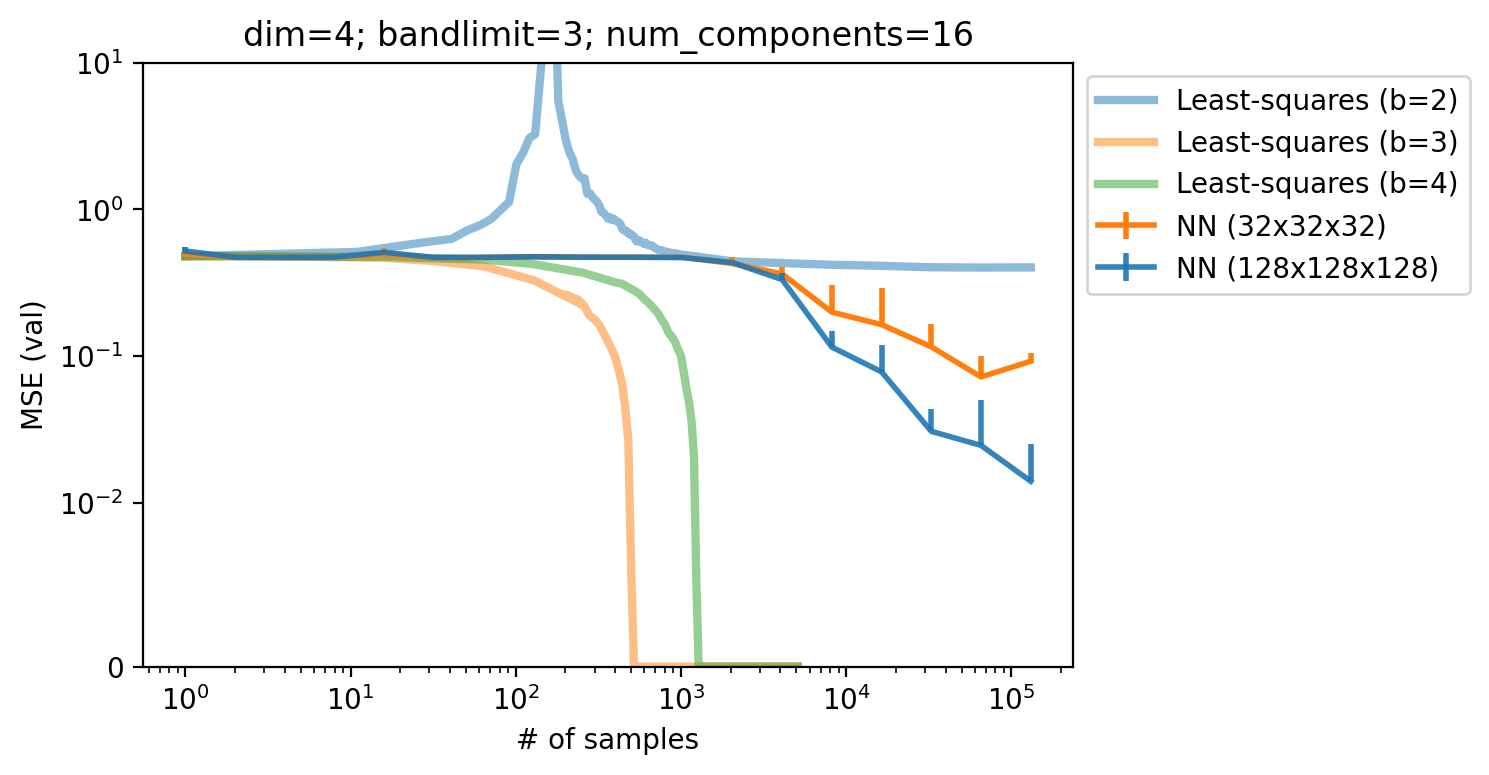

In [16]:
plt.figure(dpi=200, figsize=(6, 4))

plot_errorbar(
    xs=RUNS["b3c16n032"].ns,
    ys=RUNS["b3c16n032"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=1, zorder=8, linewidth=2, color="tab:orange",
    label="NN (32x32x32)",   
)
plot_errorbar(
    xs=RUNS["b3c16n128"].ns,
    ys=RUNS["b3c16n128"].val_mses,
    lo_q=0, mid_q=0, hi_q=1,
    alpha=0.9, zorder=9, linewidth=2, color="tab:blue",
    label="NN (128x128x128)",
)
#plot_errorbar(
#    xs=RUNS["b3c16n064"].ns,
#    ys=RUNS["b3c16n064"].val_mses,
#    lo_q=0, mid_q=0, hi_q=1,
#    alpha=0.8, zorder=10, label="NN (64x64x64)"
#)

plt.plot(LS_DATA["b3c16-b2"].ns, LS_DATA["b3c16-b2"].val_mses.min(axis=-1), label="Least-squares (b=2)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b3c16-b3"].ns, LS_DATA["b3c16-b3"].val_mses.min(axis=-1), label="Least-squares (b=3)", alpha=0.5, linewidth=3)
plt.plot(LS_DATA["b3c16-b4"].ns, LS_DATA["b3c16-b4"].val_mses.min(axis=-1), label="Least-squares (b=4)", alpha=0.5, linewidth=3)

plt.xscale("log")
plt.yscale('symlog', linthresh=1e-2); plt.ylim(0, 10)

plt.title("dim=4; bandlimit=3; num_components=16")
plt.xlabel("# of samples")
plt.ylabel("MSE (val)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1));